
## Variogram Calculation in Python with PyGSLIB / GeostatPy for Engineers, Data Scientists and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube Lectures](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)

This is a tutorial for / demonstration of **variogram calculation in Python** with the PyGSLIB package (by Adrian Martinez Vargas) that wraps some of the FORTRAN algorithms from GSLIB, Geostatistical Library (Deutsch and Journel, 1997).  I also use a couple functions form GeostatPy (by Michael Pyrcz, an informal collection of Python programs that write parameter files, data files, run GSLIB executables and then read results back and some reimplimentation of GSLIB visualization with MatPlotLib methods). The GeostatPy functions are embeded directly in the workflow.

Variogram calculation for irregularly-spaced data is available in the $gam$ algorithm from GSLIB. The methods is written about in the GSLIB book by Deutsch and Journel (1998) and other textbooks such as Pyrcz and Deutsch (2014).  The implementation is true to the GSLIB parameterization and includes the ability to calculate an array of outputs with multiple vairogram types and multiple directions all at once.  

The steps for variogram claculation include:

1. load the 2D data file
2. perform basic data checks
3. transform to standard normal
4. calculate and visualize an omnidirectional variogram
5. calculate and visualize directionals variogram

To accomplish this I have provided wrappers or reimplementation in Python for the following GSLIB methods:

1. hist - histograms plots reimplemented with GSLIB parameters using python methods
2. locmap - location maps reimplemented with GSLIB parameters using python methods
3. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

Note: If interested the GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.

I built this workflow to support my students learning about variogram calculation and also to try out the PyGSLIB package in Python.  

I created GeostatPy functions to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

I used this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to geostatistics and Python for the engineering undergraduate students. It is assumed that students have no previous Python, geostatistics nor machine learning experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes in my class.  The Python code and markdown was developed and tested in Jupyter. 

#### Load the required libraries

The following code loads the required libraries.


In [204]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import pygslib as gslib

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

GeostatsPy includes wrappers and reimplementations of GSLIB method along with 4 utilities to move between GSLIB's Geo-EAS data sets and DataFrames, and grids and 2D Numpy arrays respectively and 2 utilities to resample from regular datasets.  For this workflow we have embedded these:

1. hist
2. locmap
3. affine

For now we embed the functions in the workflow below. In the future this will be turned into a proper Python package.  Warning, there has been no attempt to make these functions robust in the precense of bad inputs.  If you get a crazy error check the inputs.  Are the arrays empty and are they the same size when they should be?  Are the arrays the correct dimension?  Is the parameter order mixed up?  Make sure the inputs are consistent with the descriptions in this document.

In [205]:
# Some GeostatsPy Functions - by Michael Pyrcz the full set is available at https://git.io/fNgR7.

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')    
    plt.show()
    return

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [206]:
os.chdir("c:/PGE337")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Load the 2D Spatial Data

The dataset '2D_MV_200Wells.csv' is available on GitHub at https://git.io/fxyMy.  Copy it to your working directory (set above) and the following code will load it as a DataFrame. We also perform basic data checks by visualizing the data and then calculating summary statistics.

In [207]:
df = pd.read_csv("2D_MV_200Wells.csv")                # read a .csv file in as a DataFrame
print(df.iloc[0:5,:])                                 # display first 4 samples in the table as a preview
df.head()                                             # we could also use this command for a table preview

      X     Y  facies_threshold_0.3  porosity  permeability  \
0   565  1485                     1    0.1184         6.170   
1  2585  1185                     1    0.1566         6.275   
2  2065  2865                     2    0.1920        92.297   
3  3575  2655                     1    0.1621         9.048   
4  1835    35                     1    0.1766         7.123   

   acoustic_impedance  
0               2.009  
1               2.864  
2               3.524  
3               2.157  
4               3.979  


,X,Y,facies_threshold_0.3,porosity,permeability,acoustic_impedance
0,565,1485,1,0.1184,6.170,2.009
1,2585,1185,1,0.1566,6.275,2.864
2,2065,2865,2,0.1920,92.297,3.524
3,3575,2655,1,0.1621,9.048,2.157
4,1835,35,1,0.1766,7.123,3.979


In [208]:
df.describe().transpose()   

,count,mean,std,min,25%,50%,75%,max
X,200.0,2053.400000,1113.524641,25.00000,1112.500000,2160.00000,2915.0000,3955.0000
Y,200.0,1876.150000,1137.580160,35.00000,920.000000,1855.00000,2782.5000,3995.0000
facies_threshold_0.3,200.0,1.330000,0.471393,1.00000,1.000000,1.00000,2.0000,2.0000
porosity,200.0,0.149300,0.032948,0.05000,0.132175,0.15015,0.1742,0.2232
permeability,200.0,25.287462,64.470135,0.01582,1.366750,4.82550,14.5970,463.6410
acoustic_impedance,200.0,3.000435,0.592201,2.00900,2.483250,2.96450,3.5270,3.9840


The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

In [209]:
xmin = 0.0; xmax = 4000.0
ymin = 0.0; ymax = 4000.0
vmin = 0.05; vmax = 0.22; cmap = plt.cm.plasma 
n = len(df)
weights = np.ones(n)

For variogram calculations we will want to visualize the data.  We do this to determine variogram search parameters such as lag distance and number of lags.  In addition, we should look for data issues (anomalous values, data coverage) and trends. 

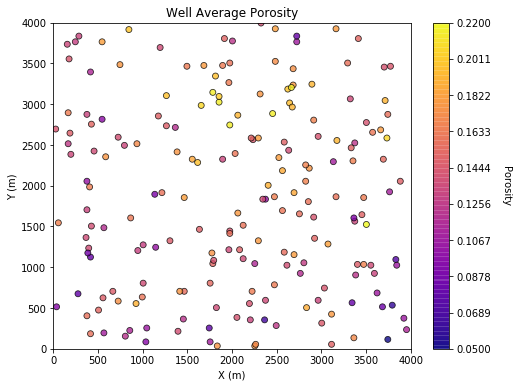

In [210]:
locmap(df,"X","Y","porosity",xmin,xmax,ymin,ymax,vmin,vmax,"Well Average Porosity","X (m)","Y (m)","Porosity",cmap)

We should also look at the distribution.  We are concerned about outliers (variogram is sensitive to outliers), distribution shape (is it already Gaussian?) and the variance as this is the sill of our experimental variogram.

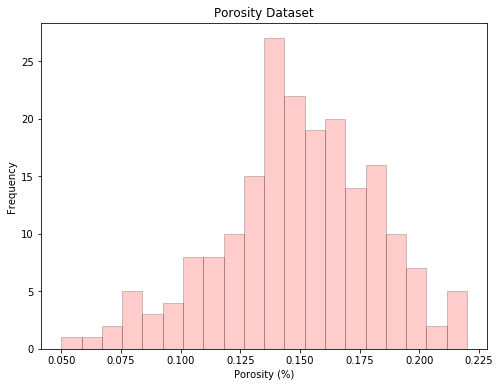

Porosity Variance =  0.0011


In [211]:
hist(df["porosity"],vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Dataset")
var = np.var(df["porosity"])
print('Porosity Variance = ',round(var,4))

Let's transform the data to standard normal (Gaussian with a mean of 0.0 and a variance of 1.0).  This would be required if we were applying the variogram in a Gaussian simulation method. 

In [212]:
t1, t2 = gslib.nonlinear.ttable(z = df['porosity'].values, w = weights)
npor = gslib.nonlinear.nscore(z = por, transin = t1, transout = t2)
df["nporosity"] = npor
var = np.var(df["nporosity"])
print('Normal Score Porosity Variance = ',round(var,4))

Normal Score Porosity Variance =  0.9908


The variogram calculation will require an Z value, since we are in 2D we will add a new 'Z' property to our DataFrame with just 0.0 values. We will check the DataFrame again to make sure we have all the variables as expected.

In [213]:
z = np.zeros(n)
df["Z"] = z
df.head()

,X,Y,facies_threshold_0.3,porosity,permeability,acoustic_impedance,nporosity,Z
0,565,1485,1,0.1184,6.170,2.009,-0.984235,0.0
1,2585,1185,1,0.1566,6.275,2.864,0.170013,0.0
2,2065,2865,2,0.1920,92.297,3.524,1.356312,0.0
3,3575,2655,1,0.1621,9.048,2.157,0.365149,0.0
4,1835,35,1,0.1766,7.123,3.979,0.730639,0.0


Now we check the histogram of the normal score transformed porosity values, 'nporosity' in our DataFrame.

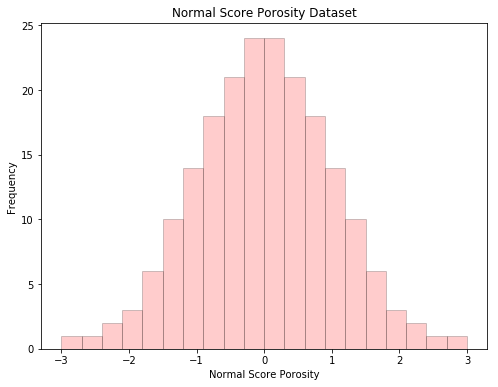

Normal Score Porosity Variance =  0.9908


In [151]:
hist(df["nporosity"],-3,3,log=False,cumul=False,bins=20,weights=None,xlabel="Normal Score Porosity",title="Normal Score Porosity Dataset")
var = np.var(df["nporosity"])
print('Normal Score Porosity Variance = ',round(var,4))

The property distribution is standard normal and we have a good idea of the parameters for the search template so we are ready to set the parameters for a 2D omnidirectional variogram calculation.  This is what's known as a library in Python. The parameters are the same as those in GSLIB, and consistent with the class notes.

In [214]:
parameters = {
        'x'      :  df['X'],          # X coordinates, array('f') with bounds (nd), nd is number of data points
        'y'      :  df['Y'],          # Y coordinates, array('f') with bounds (nd)
        'z'      :  df['Z'],          # Z coordinates, array('f') with bounds (nd)
        'bhid'   :  df['Z'],          # bhid for downhole variogram, array('i') with bounds (nd)
        'vr'     :  df["nporosity"],  # Variables, array('f') with bounds (nd,nv), nv is number of variables
        'tmin'   : -1.0e21,        # trimming limits, float
        'tmax'   :  1.0e21,        # trimming limits, float
        'nlag'   :  20,            # number of lags, int
        'xlag'   :  100,           # lag separation distance, float
        'xltol'  :  50,            # lag tolerance, float
        'azm'    :  [0],             # azimuth, array('f') with bounds (ndir)
        'atol'   :  [90],            # azimuth tolerance, array('f') with bounds (ndir)
        'bandwh' :  [9999],          # bandwidth 'horizontal', array('f') with bounds (ndir)
        'dip'    :  [0],             # dip, array('f') with bounds (ndir)
        'dtol'   :  [0],             # dip tolerance, array('f') with bounds (ndir)
        'bandwd' :  [9999],          # bandwidth 'vertical', array('f') with bounds (ndir)
        'isill'  :  0,             # standardize sills? (0=no, 1=yes), int
        'sills'  :  [1.0],           # variance used to std the sills, array('f') with bounds (nv)
        'ivtail' :  [1],             # tail var., array('i') with bounds (nvarg), nvarg is number of variograms
        'ivhead' :  [1],             # head var., array('i') with bounds (nvarg)
        'ivtype' :  [1],             # variogram type, array('i') with bounds (nvarg)
        'maxclp' :  [50000]}         # maximum number of variogram point cloud to use, input int

The PyGSLIB package includes a check method for the library.  Run this and check for error.

In [215]:
variogram_check = gslib.gslib.check_gamv_par(parameters)
if variogram_check == 1:
    print("The variogram parameters pass the test.")
else:
    print("The variogram parameters failed the test, check the errors.")

The variogram parameters pass the test.


Now we are ready to calculate a variogram.  The following includes output with lag distance (dis), variogram value (gam), number of pairs (np) and a variety of other outputs that we will not use in this workflow (check the PyGSLIB docs to learn more).

In [95]:
dis, gam, hm, tm, hv, tv, np, cldi, cldj, cldg, cldh = gslib.gslib.gamv(parameters)

Let's plot the omnidirectional variogram.  I use the MatPlotLib package to make a standard variogram plot.  Note, the outputs are arrays over variogram types and directions, by using [0][0] we indicate to use the first (and only) one.

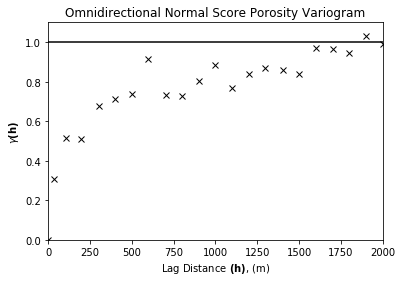

In [194]:
fig, ax = plt.subplots()
ax.plot(dis[0][0],gam[0][0],'x',color = 'black')
ax.plot([0,2000],[1.0,1.0],color = 'black')
ax.set_xlabel(r'Lag Distance $\bf(h)$, (m)')
ax.set_ylabel(r'$\gamma \bf(h)$')
ax.set_title('Omnidirectional Normal Score Porosity Variogram')
ax.set_xlim([0,2000])
ax.set_ylim([0,1.1])
plt.show()

That is a great looking variogram.  Could have a nugget, two nested spherical structures with ultimate range of aobut 1,800 m. We will cover variogram modeling in our next workflow.

Let's try directional variograms.  To do this we set the azimuths (2 of them in an array) and the azimuth tolerances (one for each).  Now we have to double up the other parameters.

In [184]:
dir_parameters = {
        'x'      :  df['X'],          # X coordinates, array('f') with bounds (nd), nd is number of data points
        'y'      :  df['Y'],          # Y coordinates, array('f') with bounds (nd)
        'z'      :  df['Z'],          # Z coordinates, array('f') with bounds (nd)
        'bhid'   :  df['Z'],          # bhid for downhole variogram, array('i') with bounds (nd)
        'vr'     :  df["nporosity"],  # Variables, array('f') with bounds (nd,nv), nv is number of variables
        'tmin'   : -1.0e21,           # trimming limits, float
        'tmax'   :  1.0e21,           # trimming limits, float
        'nlag'   :  10,               # number of lags, int
        'xlag'   :  200,              # lag separation distance, float
        'xltol'  :  100,               # lag tolerance, float
        'azm'    :  [0,90],           # azimuth, array('f') with bounds (ndir)
        'atol'   :  [22.5,22.5],           # azimuth tolerance, array('f') with bounds (ndir)
        'bandwh' :  [9999,9999],           # bandwidth 'horizontal', array('f') with bounds (ndir)
        'dip'    :  [0,0],              # dip, array('f') with bounds (ndir)
        'dtol'   :  [0,0],              # dip tolerance, array('f') with bounds (ndir)
        'bandwd' :  [9999,9999],           # bandwidth 'vertical', array('f') with bounds (ndir)
        'isill'  :  0,                # standardize sills? (0=no, 1=yes), int
        'sills'  :  [1.0],            # variance used to std the sills, array('f') with bounds (nv)
        'ivtail' :  [1],              # tail var., array('i') with bounds (nvarg), nvarg is number of variograms
        'ivhead' :  [1],              # head var., array('i') with bounds (nvarg)
        'ivtype' :  [1],              # variogram type, array('i') with bounds (nvarg)
        'maxclp' :  [50000]}          # maximum number of variogram point cloud to use, input int

We can check our variogram parameters again.

In [185]:
variogram_check = gslib.gslib.check_gamv_par(dir_parameters)
if variogram_check == 1:
    print("The variogram parameters pass the test.")
else:
    print("The variogram parameters failed the test, check the errors.")

The variogram parameters pass the test.


and run the vairogram calculation.

In [186]:
dir_dis, dir_gam, hm, tm, hv, tv, dir_np, cldi, cldj, cldg, cldh = gslib.gslib.gamv(dir_parameters)

We modified the plot to include both directional variograms with colours and legend to tell them apart.

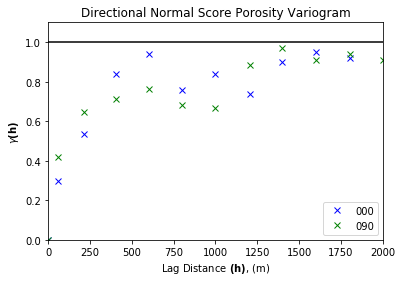

In [192]:
fig, ax = plt.subplots()
ax.plot(dir_dis[0][0],dir_gam[0][0],'x',color = 'blue',label = '000')
ax.plot(dir_dis[0][0],dir_gam[0][1],'x',color = 'green', label = '090')
ax.plot([0,2000],[1.0,1.0],color = 'black')
ax.set_xlabel(r'Lag Distance $\bf(h)$, (m)')
ax.set_ylabel(r'$\gamma \bf(h)$')
ax.set_title('Directional Normal Score Porosity Variogram')
ax.set_xlim([0,2000])
ax.set_ylim([0,1.1])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::], labels[::])
plt.show()

#### Comments

With this basic workflow it would be possible to calculate variograms in Python for any spatial dataset.  Appreciation to Adrian Martinez Vargas for the useful package, it has assisted with teaching geostatistics to my students.   

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

On twitter I'm the @GeostatsGuy.
